In [1]:
!pip install onnxmltools
!pip install skl2onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.5/352.5 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 65.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.9 MB/s eta 0:00:00


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import onnxmltools, onnxruntime as ort
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
from xgboost import XGBRegressor
from sklearn.ensemble import IsolationForest
import json, hashlib, datetime, re
import torch

models_dir = Path("/content/drive/MyDrive/TAQA/models_3")
healthy_df   = pd.read_parquet("/content/drive/MyDrive/TAQA/clean/wide36_tools_flat.parquet")
print("rows for ML:", len(healthy_df))

rows for ML: 1288266


In [3]:
IF_OPEN_FEATS   = ["Upstream-Pressure", "Downstream-Pressure"]
IF_CHOKE_FEATS   = ["Choke-Position", "ToolStateNum", "Downstream-Temperature"]
IF_FULL_FEATS   = ["Battery-Voltage", "Upstream-Pressure", "Downstream-Pressure", "Downstream-Upstream-Difference","Upstream-Temperature", "Downstream-Temperature","Choke-Position"]

# Residual targets  ➜  every model’s feature list EXCLUDES its own target
TARGETS = {
    "Battery-Voltage"        : "residual_battery.onnx",
    "Upstream-Pressure"      : "residual_upP.onnx",
    "Downstream-Pressure"    : "residual_downP.onnx",
    "Upstream-Temperature"   : "residual_upT.onnx",
    "Downstream-Temperature" : "residual_downT.onnx",
}

BASE_FEATURES = IF_FULL_FEATS.copy()

In [4]:
def export_if(df_sub,cols, onnx_path,cont):
  X = df_sub[cols].astype(np.float32).values
  model = IsolationForest(n_estimators=200, contamination=cont, random_state=42).fit(X)
  onnx  = convert_sklearn(model, initial_types=[('input', FloatTensorType([None, X.shape[1]]))],
                            target_opset={'':12, 'ai.onnx.ml':3})
  meta  = onnx.metadata_props.add()
  meta.key, meta.value = "feature_names", ','.join(cols)
  onnx_path.parent.mkdir(parents=True, exist_ok=True)
  onnx_path.write_bytes(onnx.SerializeToString())
  print("✓", onnx_path.name)

# 3-D choke
export_if(healthy_df, IF_CHOKE_FEATS,
          models_dir/"choke_position.onnx", 0.01)

# 1-D ΔT open (only IsOpen==1)
export_if(healthy_df.loc[healthy_df["IsOpen"]==1],["DeltaTemperature"],
          models_dir/"delta_temp_open.onnx", 0.01)

# 2-D pressure pair open
export_if(healthy_df.loc[healthy_df["IsOpen"]==1],IF_OPEN_FEATS,
          models_dir/"pressure_pair_open.onnx", 0.01)

# 7-D full vector
export_if(healthy_df, IF_FULL_FEATS,
          models_dir/"full_vectors_if.onnx", 0.05)


✓ choke_position.onnx
✓ delta_temp_open.onnx
✓ pressure_pair_open.onnx
✓ full_vectors_if.onnx


In [5]:
# ── 0. columns that are always log-scaled when they appear as predictors ──
LOG_FEATURES = ["Upstream-Pressure",
                "Downstream-Pressure",
                "Downstream-Upstream-Difference"]

def make_X(df, feats, target):
    """Return design-matrix with log1p on LOG_FEATURES except the target."""
    X = df[feats].copy()
    for c in LOG_FEATURES:
        if c in X.columns and c != target:          # skip the target itself
            X[c] = np.log1p(X[c].clip(lower=0))
    return X.astype(np.float32).values


mad_dict = {}
all_resids = {}

# ── classic 5 residuals ────────────────────────────────────────────
for target, fname in TARGETS.items():
    feats = [f for f in BASE_FEATURES if f != target]      # target excluded
    X     = make_X(healthy_df, feats, target)
    y     = healthy_df[target].values.astype(np.float32)   # linear units

    model = XGBRegressor(
              n_estimators=200, max_depth=4, learning_rate=0.1,
              subsample=0.9, colsample_bytree=0.9,
              tree_method='hist', random_state=42).fit(X, y)

    onnx = onnxmltools.convert_xgboost(
              model, name=target,
              initial_types=[("input", FloatTensorType([None, X.shape[1]]))],
              target_opset=12)
    meta = onnx.metadata_props.add()
    meta.key, meta.value = "feature_names", ",".join(feats)
    (models_dir/fname).write_bytes(onnx.SerializeToString())
    print("✓", fname)

    resid = np.abs(y - model.predict(X))
    mad   = np.median(np.abs(resid - np.median(resid)))
    cut   = np.percentile(resid, 99)
    mad_dict[target] = {"mad": float(mad), "cutoff": float(cut)}

# ── Target-Position  →  Choke-Position residual ───────────────────
RES_FEATS = ["Target-Position", "ToolStateNum"]
TARGET_CHOKE = "Choke-Position"

X_res = healthy_df[RES_FEATS].astype(np.float32).values        # no log
y_res = healthy_df[TARGET_CHOKE].astype(np.float32).values

xgb_res = XGBRegressor(
    n_estimators=200, max_depth=4, learning_rate=0.1,
    subsample=0.9, colsample_bytree=0.9, tree_method='hist',
    random_state=42).fit(X_res, y_res)

onnx_res = onnxmltools.convert_xgboost(
    xgb_res, name="target_pos_residual",
    initial_types=[("input", FloatTensorType([None, len(RES_FEATS)]))])
meta = onnx_res.metadata_props.add()
meta.key, meta.value = "feature_names", ",".join(RES_FEATS)
(models_dir/"target_pos_residual.onnx").write_bytes(onnx_res.SerializeToString())
print("✓ target_pos_residual.onnx saved")

resid_tp = np.abs(xgb_res.predict(X_res) - y_res)
mad_tp   = np.median(np.abs(resid_tp - np.median(resid_tp)))
cut_tp   = np.percentile(resid_tp, 99)        # or mad_mult*mad_tp
mad_dict["Target-Position"] = {"mad": float(mad_tp), "cutoff": float(cut_tp)}

# ── write combined JSON ────────────────────────────────────────────
(models_dir/"residual_mad.json").write_text(json.dumps(mad_dict, indent=2))
print("✓ residual_mad.json updated")


✓ residual_battery.onnx
✓ residual_upP.onnx
✓ residual_downP.onnx
✓ residual_upT.onnx
✓ residual_downT.onnx
✓ target_pos_residual.onnx saved
✓ residual_mad.json updated


In [6]:
def sha(fp):
    h = hashlib.sha256()
    with open(fp, "rb") as f:
        h.update(f.read())
    return h.hexdigest()[:12]

manifest = {"timestamp": datetime.datetime.utcnow().isoformat(timespec="seconds")+"Z",
            "files": {}}

for fp in sorted(Path(models_dir).glob("*.onnx")):
    sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
    n    = sess.get_inputs()[0].shape[1] or 1
    sess.run(None, {"input": np.zeros((1, n), np.float32)})   # smoke test
    manifest["files"][fp.name] = sha(fp)
    print(f"{fp.name:30s} ✔")

# include MAD JSON too
mad_json = Path(models_dir)/"residual_mad.json"
manifest["files"][mad_json.name] = sha(mad_json)

with open(Path(models_dir)/"model_manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)

print("\n📄 model_manifest.json written")

choke_position.onnx            ✔
delta_temp_open.onnx           ✔
full_vectors_if.onnx           ✔
pressure_pair_open.onnx        ✔
residual_battery.onnx          ✔
residual_downP.onnx            ✔
residual_downT.onnx            ✔
residual_upP.onnx              ✔
residual_upT.onnx              ✔
target_pos_residual.onnx       ✔

📄 model_manifest.json written


In [ ]:
sess = ort.InferenceSession((models_dir/"residual_upP.onnx").as_posix())
order = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')
print(order)      # now prints the 6 column names in correct order

['Battery-Voltage', 'Downstream-Pressure', 'Downstream-Upstream-Difference', 'Upstream-Temperature', 'Downstream-Temperature', 'Choke-Position']


In [7]:
models_dir = Path("/content/drive/MyDrive/TAQA/models_3")
data_df    = healthy_df.copy()
mad_limits = json.load(open(models_dir/"residual_mad.json"))

def build_X(df, cols):
    return df[cols].astype(np.float32).values

def alert_if(sess, X):
    labels, _ = sess.run(None, {"input": X})
    return labels.squeeze() == -1          # IF label –1 = anomaly

def alert_residual(sess, X, y, cutoff):
    y_hat = sess.run(None, {"input": X})[0].squeeze()
    return np.abs(y - y_hat) > cutoff

# map residual file-stem → target column
RES_MAP = {
    "residual_battery"  : "Battery-Voltage",
    "residual_upP"      : "Upstream-Pressure",
    "residual_downP"    : "Downstream-Pressure",
    "residual_upT"      : "Upstream-Temperature",
    "residual_downT"    : "Downstream-Temperature",
    "target_pos_residual": "Choke-Position",          # NEW
}

results = {}

for fp in sorted(models_dir.glob("*.onnx")):
    name = fp.stem

    try:
        sess = ort.InferenceSession(fp.as_posix(), providers=["CUDAExecutionProvider"])
    except Exception as e:
        print(f"Falling back to CPU for model {fp.name} due to: {e}")
        sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])

    cols = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')

    if name in RES_MAP:                       # ── residual models
        tgt_col = RES_MAP[name]
        X       = make_X(data_df, cols, tgt_col)     # << changed
        y       = data_df[tgt_col].values                 # linear units
        cutoff  = (mad_limits["Target-Position"]["cutoff"]
                   if name == "target_pos_residual"
                   else mad_limits[tgt_col]["cutoff"])
        alert   = alert_residual(sess, X, y, cutoff)

    elif name == "pressure_pair_open":
        open_rows = data_df["IsOpen"] == 1
        X = np.log1p(
              data_df.loc[open_rows,
                           ["Upstream-Pressure", "Downstream-Pressure"]]
              .clip(lower=0)
            ).astype(np.float32).values
        alert = alert_if(sess, X)
        results[name] = alert.sum() / len(data_df) * 100
        continue

    elif name == "delta_temp_open":
        open_rows = data_df["IsOpen"] == 1
        X = data_df.loc[open_rows, ["DeltaTemperature"]].astype(np.float32).values
        alert = alert_if(sess, X)
        results[name] = alert.sum() / len(data_df) * 100
        continue

    else:                                     # other Isolation-Forests
        X      = data_df[cols].astype(np.float32).values
        alert  = alert_if(sess, X)

    results[name] = alert.mean() * 100          # % of rows flagged

# pretty-print
print("\n% rows flagged (training data)\n" + "-"*35)
for k, v in sorted(results.items(), key=lambda x: x[1]):
    print(f"{k:<25s} : {v:6.2f} %")


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available prov


% rows flagged (training data)
-----------------------------------
pressure_pair_open        :   0.00 %
delta_temp_open           :   0.67 %
target_pos_residual       :   0.99 %
residual_battery          :   0.99 %
choke_position            :   1.00 %
residual_downP            :   1.00 %
residual_upP              :   1.00 %
residual_downT            :   1.00 %
residual_upT              :   1.00 %
full_vectors_if           :   4.99 %


In [ ]:
sess      = ort.InferenceSession((models_dir/"residual_downP.onnx").as_posix())
cols      = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')
print("feature order in ONNX →", cols)

# build design-matrix exactly as the model saw it
X_dbg = data_df[cols].copy()
for c in ["Upstream-Pressure", "Downstream-Upstream-Difference"]:
    if c in X_dbg.columns:                      # must be log1p-scaled
        X_dbg[c] = np.log1p(X_dbg[c].clip(lower=0))

y_hat  = sess.run(None, {"input": X_dbg.astype(np.float32).values})[0].squeeze()
resid  = np.abs(data_df["Downstream-Pressure"].values - y_hat)

print("cut-off in JSON     :", mad_limits["Downstream-Pressure"]["cutoff"])
print("resid 50/95/99 pctl :", np.percentile(resid, [50, 95, 99]))


feature order in ONNX → ['Battery-Voltage', 'Upstream-Pressure', 'Downstream-Upstream-Difference', 'Upstream-Temperature', 'Downstream-Temperature', 'Choke-Position']
cut-off in JSON     : 34.440860748291016
resid 50/95/99 pctl : [  2.95807293  55.24183633 167.61356199]


In [ ]:
flag_rows = data_df.loc[resid > mad_limits["Downstream-Pressure"]["cutoff"]]
display(flag_rows.head(10))


param,Tool,Battery-Voltage,Choke-Position,Downstream-Pressure,Downstream-Temperature,Downstream-Upstream-Difference,Target-Position,Tool-State,Upstream-Pressure,Upstream-Temperature,IsOpen,DeltaTemperature,ToolStateNum,RuleAlert
Timestamp,,,,,,,,,,,,,,
2025-02-17 09:13:58.625238400+00:00,P8-1,14.15137,100.1351,71.43204,14.13058,5.496353,100.0,1,65.93568,14.21094,1,0.08036,1.0,False
2025-02-17 09:13:59.626325200+00:00,P8-1,14.15137,100.1351,74.49277,14.13062,5.641602,100.0,1,68.85117,14.21103,1,0.08041,1.0,False
2025-02-17 09:14:00.629303700+00:00,P8-1,14.14728,100.1351,78.26601,14.13071,5.723312,100.0,1,72.54269,14.21112,1,0.08041,1.0,False
2025-02-17 09:14:01.645254200+00:00,P8-1,14.14728,100.1351,82.77336,14.13092,5.818146,100.0,1,76.95522,14.21121,1,0.08029,1.0,False
2025-02-17 09:14:02.647327600+00:00,P8-1,14.15137,100.1351,88.10997,14.13101,5.929871,100.0,1,82.18010,14.21136,1,0.08035,1.0,False
2025-02-17 09:14:03.649303200+00:00,P8-1,14.14728,100.1351,94.69147,14.13110,6.058716,100.0,1,88.63275,14.21155,1,0.08045,1.0,False
2025-02-17 09:14:04.648266800+00:00,P8-1,14.15137,100.1351,102.55800,14.13138,6.113693,100.0,1,96.44429,14.21173,1,0.08035,1.0,False
2025-02-17 09:14:05.646278+00:00,P8-1,14.15137,100.1351,111.78080,14.13144,6.135529,100.0,1,105.64530,14.21182,1,0.08038,1.0,False
2025-02-17 09:14:06.664275900+00:00,P8-1,14.15137,100.1351,122.69080,14.13181,6.110199,100.0,1,116.58060,14.21213,1,0.08032,1.0,False


In [ ]:
X_dP = data_df[cols_dP].copy()

LOG_COLS = ["Upstream-Pressure",
            "Downstream-Upstream-Difference"]   # ← both were log-scaled

X_dP = data_df[cols_dP].copy()
for c in LOG_COLS:
    X_dP[c] = np.log1p(X_dP[c].clip(lower=0))

X_dP = X_dP.astype(np.float32).values


In [ ]:
y_hat  = sess_dP.run(None, {"input": X_dP})[0].squeeze()
resid  = np.abs(data_df["Downstream-Pressure"].values - y_hat)

print("cut-off in file :", mad_limits["Downstream-Pressure"]["cutoff"])
print("p90 / p95 / p99 :", np.percentile(resid, [90, 95, 99]))

cut-off in file : 33.129940032958984
p90 / p95 / p99 : [1779.99601973 2279.33406865 3284.25890023]


In [ ]:
models_dir  = Path("/content/drive/MyDrive/TAQA/models_3")
mad_limits  = json.load(open(models_dir/"residual_mad.json"))

LOG_FEATURES = ["Upstream-Pressure", "Downstream-Pressure",
                "Downstream-Upstream-Difference"]

def make_X_eval(df, cols, target):
    X = df[cols].copy()
    for c in LOG_FEATURES:
        if c in X.columns and c != target:
            X[c] = np.log1p(X[c].clip(lower=0))
    return X.astype(np.float32).values

def alert_if(sess, X):
    lbl, _ = sess.run(None, {"input": X})
    return lbl.squeeze() == -1

def alert_residual(sess, X, y, cutoff):
    y_hat = sess.run(None, {"input": X})[0].squeeze()
    return np.abs(y - y_hat) > cutoff

# map residual file-stem → target column (keep in sync!)
RES_MAP = {
    "residual_battery"   : "Battery-Voltage",
    "residual_upP"       : "Upstream-Pressure",
    "residual_downP"     : "Downstream-Pressure",
    "residual_upT"       : "Upstream-Temperature",
    "residual_downT"     : "Downstream-Temperature",
    "target_pos_residual": "Choke-Position",
}

# ── choose the data slice you regard as “clean” ─────────────────────
data_df = pd.read_parquet("/content/drive/MyDrive/TAQA/clean/wide_tools_full.parquet")
df = data_df.copy()                       # already rule-clean
rule_mask = df["RuleAlert"].values           # True where a rule fired

# ── loop over every .onnx in the directory ──────────────────────────
rows = []
for fp in sorted(models_dir.glob("*.onnx")):
    name  = fp.stem
    try:
        sess = ort.InferenceSession(fp.as_posix(), providers=["CUDAExecutionProvider"])
    except Exception as e:
        print(f"Falling back to CPU for model {fp.name} due to: {e}")
        sess = ort.InferenceSession(fp.as_posix(), providers=["CPUExecutionProvider"])
    cols  = sess.get_modelmeta().custom_metadata_map["feature_names"].split(',')

    # decide evaluation path
    if name in RES_MAP:                                   # residual models
        tgt = RES_MAP[name]
        X   = make_X_eval(df, cols, tgt)
        y   = df[tgt].values
        cut = mad_limits[tgt]["cutoff"] \
              if name != "target_pos_residual" else mad_limits["Target-Position"]["cutoff"]
        alert = alert_residual(sess, X, y, cut)

    elif name == "pressure_pair_open":
        open_rows = df["IsOpen"] == 1
        X   = np.log1p(df.loc[open_rows,
                              ["Upstream-Pressure","Downstream-Pressure"]]
                        .clip(lower=0)).astype(np.float32).values
        alert = np.zeros(len(df), bool)
        alert[open_rows] = alert_if(sess, X)

    elif name == "delta_temp_open":
        open_rows = df["IsOpen"] == 1
        X   = df.loc[open_rows, ["DeltaTemperature"]].astype(np.float32).values
        alert = np.zeros(len(df), bool)
        alert[open_rows] = alert_if(sess, X)

    else:                                                 # other IFs
        X     = df[cols].astype(np.float32).values
        alert = alert_if(sess, X)

    # metrics
    fp_rate   = 100 * alert.mean()
    tp_onrule = (alert & rule_mask).sum()
    prec_rule = tp_onrule / alert.sum() if alert.any() else np.nan
    extra_pct = 100 * (alert & ~rule_mask).mean()

    rows.append((name, fp_rate, prec_rule, extra_pct))

# ── pretty table ────────────────────────────────────────────────────
out = pd.DataFrame(rows, columns=["Detector", "FP-rate %", "Prec vs Rule", "Extra %"])\
         .set_index("Detector")\
         .sort_values("FP-rate %")
display(out.style.format({"FP-rate %":"{:.2f}",
                          "Prec vs Rule":"{:.2f}",
                          "Extra %":"{:.2f}"}))


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available prov

,FP-rate %,Prec vs Rule,Extra %
Detector,,,
pressure_pair_open,0.00,nan,0.00
target_pos_residual,2.38,0.63,0.87
choke_position,2.89,0.70,0.86
residual_upP,4.90,0.82,0.89
residual_downP,5.33,0.83,0.89
delta_temp_open,7.99,0.92,0.60
residual_upT,8.93,0.90,0.89
residual_downT,8.96,0.90,0.89
residual_battery,9.70,0.91,0.88


In [8]:
import onnxruntime as rt, numpy as np, pandas as pd

def log1p_cols(df, cols):
    df = df.copy()
    for c in cols:
        df[c] = np.log1p(np.clip(df[c], 0, None))
    return df



sess = rt.InferenceSession("/content/drive/MyDrive/TAQA/models_3/residual_downP.onnx")   # same ONNX file used in webapp
feats = sess.get_modelmeta().custom_metadata_map["feature_names"].split(",")

row = pd.read_csv("/content/drive/MyDrive/TAQA/eval/p-36 quick test.csv").iloc[0]
X = log1p_cols(row, ["Upstream-Pressure",
                    "Downstream-Pressure",
                    "Downstream-Upstream-Difference"])
new_X = np.array([[X[f] for f in feats]], dtype=np.float32)

yhat = sess.run(None, {"input": new_X})[0][0, 0]
print("Python ONNX pred:", yhat)

Python ONNX pred: 2737.6309


In [4]:
healthy_df["Downstream-Pressure"].describe()
# max is probably a few hundred psi

,Downstream-Pressure
count,1.259877e+06
mean,5.440650e+02
std,1.006058e+03
min,1.440000e+00
25%,1.425009e+01
50%,1.543050e+01
75%,9.714851e+02
max,1.093298e+04


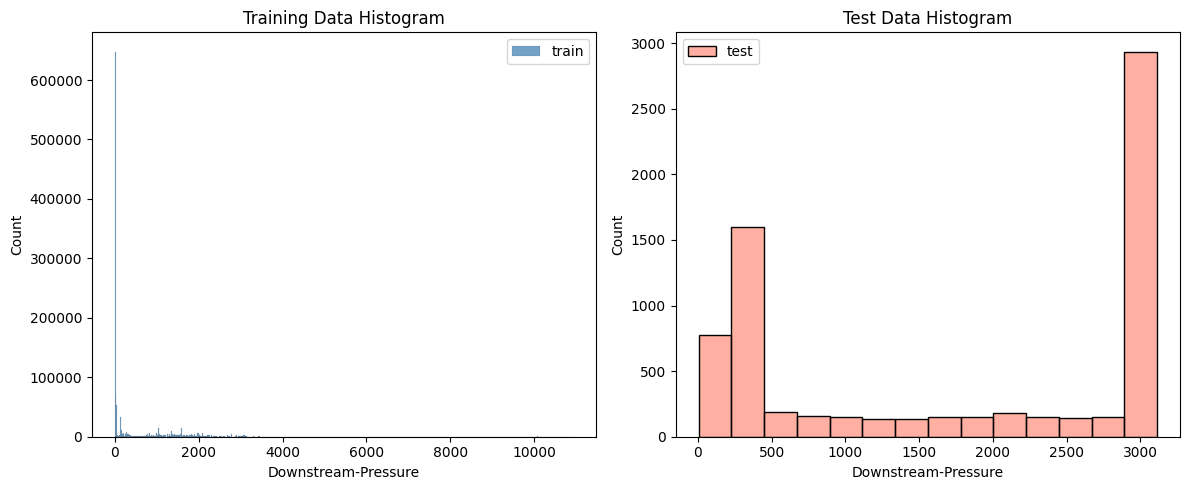

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

P36_df   = pd.read_parquet("/content/drive/MyDrive/TAQA/clean/wide_P8-36_full.parquet")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot the first histogram on the first subplot (axes[0])
sns.histplot(healthy_df["Downstream-Pressure"], color="steelblue", label="train", ax=axes[0])
axes[0].set_title("Training Data Histogram")
axes[0].legend()

# Plot the second histogram on the second subplot (axes[1])
sns.histplot(P36_df["Downstream-Pressure"], color="tomato", label="test", alpha=0.5, ax=axes[1])
axes[1].set_title("Test Data Histogram")
axes[1].legend()

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()
#plt.xlim(0, 4000)